## Problem 1 (11 pts)

Consider the problem 

$$ \min_x \frac{1}{2} \| A x - b \|_2^2, $$

where matrix $A \in \mathbb{R}^{m \times n}$ ($m > n$) and vector $b$ are given.

- (1 pts) Derive the mathematical expression of stochastic gradient of this objective function for different size of batch 
- (5 pts) Implement SAG algorithm
- (5 pts) Compare the convergence of SAG, SGD and ADAM for this simple problem for $m \sim 10^3$ and $n \sim 10^2$ and random data. Test different step size selection strategies (at least two) in SAG and SGD. Plot convergence plots for every experiment and make a conclusion about the performance of the studied methods in this particular problem.

In this problem you can use automatic differentiation framework (JAX or PyTorch)

## Solution:

In [1]:
def f(x, A, b):
    return 1/2 * sum((A.T @ x.T - b) ** 2)
    
def grad(x, A, b):
    return A @ ((A.T @ x - b))

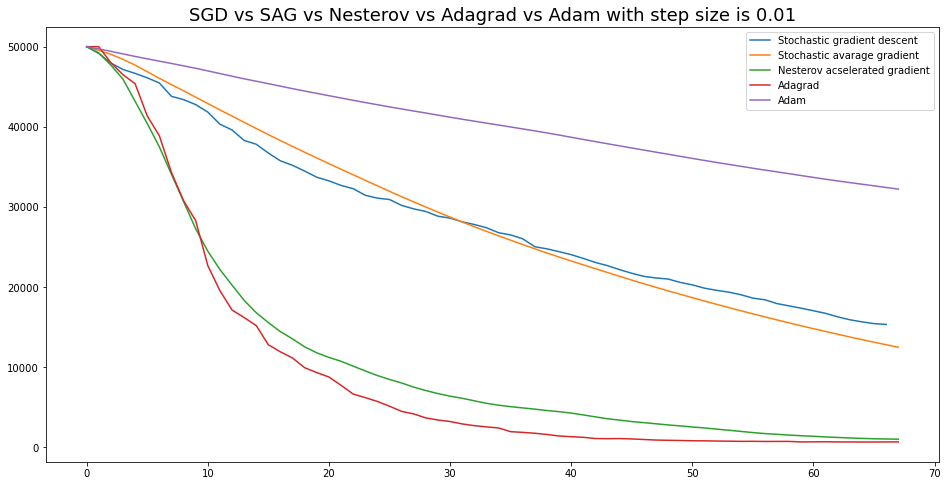

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sgd(grad, x, A, b, nimi_batch, epochs, alpha):
    score_by_epoch = [f(x, A, b)]
    for epch in range(epochs):
        scor_per_step = [f(x, A, b)]
        for _ in range(b.shape[0] // nimi_batch):
            randomize = np.arange(len(b))
            np.random.shuffle(randomize)
            A = A[:,randomize]
            b = b[randomize]
            A_random = A[:,:nimi_batch]
            b_random = b[:nimi_batch]
            gradient = grad(x, A_random, b_random)
            x -= alpha * gradient /  nimi_batch
            scor_per_step.append(f(x, A, b))
        score_by_epoch.append(f(x, A, b))
    return x, score_by_epoch, scor_per_step


def sag(grad, x, A, b, nimi_batch, epochs, alpha):
    score_by_epoch = [f(x, A, b)]
    for epch in range(epochs):
        randomize = np.arange(len(b))
        np.random.shuffle(randomize)
        A = A[:,randomize]
        b = b[randomize]
        step = 0
        previos_grad = []
        scor_per_step = [f(x, A, b)]
        while step < b.shape[0]:
            A_batch = A[:, step: step + nimi_batch]
            b_batch = b[step: step + nimi_batch]
            gradient = grad(x, A_batch, b_batch) / len(b_batch)
            previos_grad.append(gradient)
            x -= alpha * (sum(previos_grad) / len(previos_grad))
            step += nimi_batch
            scor_per_step.append(f(x, A, b))
        score_by_epoch.append(f(x, A, b))
    return x, score_by_epoch, scor_per_step

def nesterov_acselerated_gradient(grad, x, A, b, nimi_batch, epochs, alpha, momentum):
    score_by_epoch = [f(x, A, b)]
    for epch in range(epochs):
        randomize = np.arange(len(b))
        np.random.shuffle(randomize)
        A = A[:,randomize]
        b = b[randomize]
        step = 0
        previos_grad = 0
        scor_per_step = [f(x, A, b)]
        while step < b.shape[0]:
            A_batch = A[:, step: step + nimi_batch]
            b_batch = b[step: step + nimi_batch]
            nesterov_gradient = (
                previos_grad * momentum 
                + alpha * grad(x - previos_grad * momentum, A_batch, b_batch) / len(b_batch)
            )
            x -= nesterov_gradient
            step += nimi_batch
            previos_grad = nesterov_gradient
            scor_per_step.append(f(x, A, b))
        score_by_epoch.append(f(x, A, b))
    return x, score_by_epoch, scor_per_step

def adagrad(grad, x, A, b, nimi_batch, epochs, alpha, eps):
    score_by_epoch = [f(x, A, b)]
    for epch in range(epochs):
        randomize = np.arange(len(b))
        np.random.shuffle(randomize)
        A = A[:,randomize]
        b = b[randomize]
        step = 0
        sum_sq_of_grads = np.zeros(x.shape)
        scor_per_step = [f(x, A, b)]
        while step < b.shape[0]:
            A_batch = A[:, step: step + nimi_batch]
            b_batch = b[step: step + nimi_batch]
            gradient = grad(x, A_batch, b_batch) / len(b_batch)
            x = x - (alpha * (sum_sq_of_grads + eps) ** 0.5) * gradient
            step += nimi_batch
            sum_sq_of_grads += gradient ** 2 
            scor_per_step.append(f(x, A, b))
        score_by_epoch.append(f(x, A, b))
    return x, score_by_epoch, scor_per_step

def adam(grad, x, A, b, nimi_batch, epochs, alpha, eps, beta_1, beta_2):
    score_by_epoch = [f(x, A, b)]
    for epch in range(epochs):
        randomize = np.arange(len(b))
        np.random.shuffle(randomize)
        A = A[:,randomize]
        b = b[randomize]
        step = 0
        sum_sq_of_grads = np.zeros(x.shape)
        scor_per_step = [f(x, A, b)]
        m = 0 
        v = 0 
        t = 0
        
        while step < b.shape[0]:
            A_batch = A[:, step: step + nimi_batch]
            b_batch = b[step: step + nimi_batch]
            t+=1
            g = grad(x, A_batch, b_batch) / len(b_batch)
            m = beta_1 * m + (1 - beta_1) * g
            v = beta_2 * v + (1 - beta_2) * np.power(g, 2)
            m_hat = m / (1 - np.power(beta_1, t))
            v_hat = v / (1 - np.power(beta_2, t))
            x = x - alpha * m_hat / (np.sqrt(v_hat) + eps)
            step += nimi_batch
            scor_per_step.append(f(x, A, b))
        score_by_epoch.append(f(x, A, b))
    return x, score_by_epoch, scor_per_step


n = 100
m = 1000
x0 = np.random.randn(n)
A = np.random.randn(n,m)
b = np.random.randn(m)
alpha = 1e-2
nimi_batch = 15
epochs = 1
momentum = 0.9
eps = 1e-8
beta_1 = 0.9
beta_2 = 0.999


_, sgd_score, sgd_scor_per_step = sgd(grad, x0.copy(), A, b, nimi_batch, epochs, alpha)
_, sag_score, sag_scor_per_step = sag(grad, x0.copy(), A, b, nimi_batch, epochs, alpha)
_, nesterov_score, nest_scor_per_step = nesterov_acselerated_gradient(grad, x0.copy(), A, b, nimi_batch, epochs, alpha, momentum)
_, ada_score, ada_scor_per_step = adagrad(grad, x0.copy(), A, b, nimi_batch, epochs, alpha, eps)
_, ada_score, adam_scor_per_step = adam(grad, x0.copy(), A, b, nimi_batch, epochs, alpha, eps, beta_1, beta_2)
plt.figure(figsize=(16,8))
plt.plot(sgd_scor_per_step, label='Stochastic gradient descent')
plt.plot(sag_scor_per_step, label='Stochastic avarage gradient')
plt.plot(nest_scor_per_step, label='Nesterov acselerated gradient')
plt.plot(ada_scor_per_step, label='Adagrad')
plt.plot(adam_scor_per_step, label='Adam')
plt.legend()
plt.title(f'SGD vs SAG vs Nesterov vs Adagrad vs Adam with step size is {alpha}', fontsize=18)
plt.show()



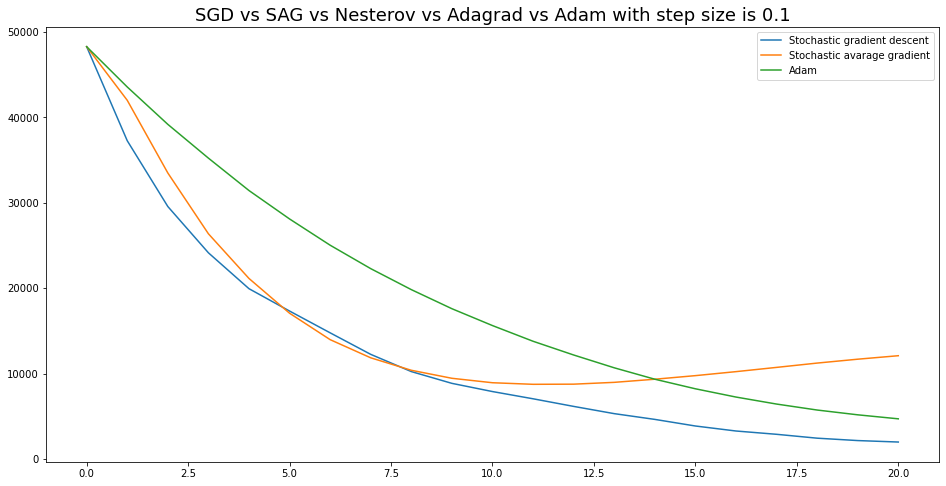

In [3]:
n = 100
m = 1000
x0 = np.random.randn(n)
A = np.random.randn(n,m)
b = np.random.randn(m)
alpha = 1e-1
nimi_batch = 50
epochs = 1
momentum = 0.9
eps = 1e-8
beta_1 = 0.9
beta_2 = 0.999


_, sgd_score, sgd_scor_per_step = sgd(grad, x0.copy(), A, b, nimi_batch, epochs, alpha)
_, sag_score, sag_scor_per_step = sag(grad, x0.copy(), A, b, nimi_batch, epochs, alpha)
_, nesterov_score, nest_scor_per_step = nesterov_acselerated_gradient(grad, x0.copy(), A, b, nimi_batch, epochs, alpha, momentum)
_, ada_score, ada_scor_per_step = adagrad(grad, x0.copy(), A, b, nimi_batch, epochs, alpha, eps)
_, ada_score, adam_scor_per_step = adam(grad, x0.copy(), A, b, nimi_batch, epochs, alpha, eps, beta_1, beta_2)
plt.figure(figsize=(16,8))
plt.plot(sgd_scor_per_step, label='Stochastic gradient descent')
plt.plot(sag_scor_per_step, label='Stochastic avarage gradient')
# plt.plot(nest_scor_per_step, label='Nesterov acselerated gradient')
# plt.plot(ada_scor_per_step, label='Adagrad')
plt.plot(adam_scor_per_step, label='Adam')
plt.legend()
plt.title(f'SGD vs SAG vs Nesterov vs Adagrad vs Adam with step size is {alpha}', fontsize=18)
plt.show()



## Conclusion
With this function better handle Nesterov acselerated gragient, and it's look logical, because we have longe slope, and acselerated method reach bigger speed according to another gradient method.

## Problem 2 (15 pts)

Consider the optimization problem from the problem 3 in assignment 6. 
- (10 pts) Compare ADAM, SGD and accelerated gradient method that uses stochastic gradient estimation on this problem and discuss what method works better and why? 
- (5 pts) Illustrate your conclusion by convergence plots and test different strategies of step size selection. 

## Solution:

$$ -\frac{1}{m} \sum_{i=1}^m (y_i \log(h(w, b | x_i)) + (1 - y_i)\log(1 - h(w, b | x_i))) \to \min_{w, b},$$

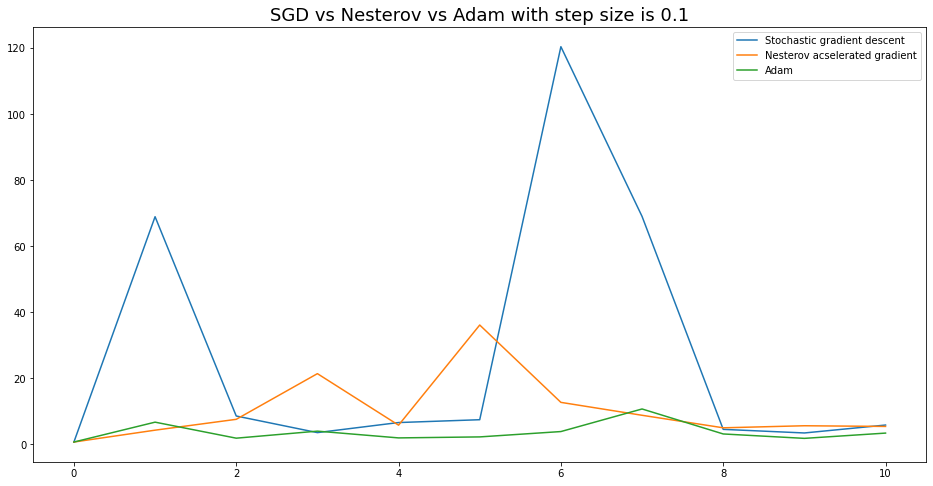

In [55]:
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

x = load_breast_cancer()['data']
new_x = np.ones((x.shape[0],x.shape[1] + 1))
new_x[:,1:] = x
x = new_x

y = load_breast_cancer()['target']
w = np.zeros(x.shape[1])

def sigmoid(arr):
    "Numerically stable sigmoid function."
    res = []
    for x in arr:
        if x >= 0:
            z = np.exp(-x)
            res.append(1 / (1 + z))
        else:
            # if x is less than zero then z will be small, denom can't be
            # zero because it's 1+z.
            z = np.exp(x)
            res.append(z / (1 + z))
    return np.array(res)


def log_reg(x, w):
    return sigmoid(x @ w)
    

def f(**kwargs):
    y = kwargs['y']
    y_pred = log_reg(kwargs['x'], kwargs['w'])
    constant = 1e-10
    y_pred[y_pred == 0] = constant
    y_pred[y_pred == 1] = 1 - constant
    m = y.shape[0]
    return -1/m * sum(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred))


def grad(**kwargs):
    y = kwargs['y']
    y_pred = log_reg(kwargs['x'], kwargs['w'])
    x = kwargs['x']
    m = x.shape[0]
    return  1 / m * x.T @ (y_pred - y) 


alpha = 1e-1
nimi_batch = 30
epochs = 10
momentum = 0.9
eps = 1e-8
beta_1 = 0.9
beta_2 = 0.999


def sgd(grad, w, x, y, nimi_batch, epochs, alpha):
    score_by_epoch = [f(x=x, w=w, y=y)]
    for epch in range(epochs):
        scor_per_step = [f(x=x, w=w, y=y)]
        for _ in range(y.shape[0] // nimi_batch):
            randomize = np.arange(len(y))
            np.random.shuffle(randomize)
            x = x[randomize]
            y = y[randomize]
            x_random = x[:nimi_batch]
            y_random = y[:nimi_batch]
            gradient = grad(x=x_random, w=w, y=y_random)
            w -= alpha * gradient /  nimi_batch
            scor_per_step.append(f(x=x, w=w, y=y))
        score_by_epoch.append(f(x=x, w=w, y=y))
    return w, score_by_epoch, scor_per_step

def nesterov_acselerated_gradient(grad, w, x, y, nimi_batch, epochs, alpha, momentum):
    score_by_epoch = [f(x=x, w=w, y=y)]
    for epch in range(epochs):
        randomize = np.arange(len(y))
        np.random.shuffle(randomize)
        x = x[randomize]
        y = y[randomize]
        step = 0
        previos_grad = 0
        scor_per_step = [f(x=x, w=w, y=y)]
        while step < y.shape[0]:
            x_batch = x[step: step + nimi_batch]
            y_batch = y[step: step + nimi_batch]
            nesterov_gradient = (
                previos_grad * momentum 
                + alpha * grad(x=x_batch, w=(w-previos_grad * momentum), y=y_batch) / len(y_batch)
            )
            w -= nesterov_gradient
            step += nimi_batch
            previos_grad = nesterov_gradient
            scor_per_step.append(f(x=x, w=w, y=y))
        score_by_epoch.append(f(x=x, w=w, y=y))
    return w, score_by_epoch, scor_per_step


def adam(grad, w, x, y, nimi_batch, epochs, alpha, eps, beta_1, beta_2):
    score_by_epoch = [f(x=x, w=w, y=y)]
    for epch in range(epochs):
        randomize = np.arange(len(y))
        np.random.shuffle(randomize)
        x = x[randomize]
        y = y[randomize]
        sum_sq_of_grads = np.zeros(w.shape)
        scor_per_step = [f(x=x, w=w, y=y)]
        m = 0 
        v = 0 
        t = 0
        step = 0
        while step < y.shape[0]:
            x_batch = x[step: step + nimi_batch]
            y_batch = y[step: step + nimi_batch]
            t+=1
            g = grad(x=x_batch, w=w, y=y_batch) / len(y_batch)
            m = beta_1 * m + (1 - beta_1) * g
            v = beta_2 * v + (1 - beta_2) * np.power(g, 2)
            m_hat = m / (1 - np.power(beta_1, t))
            v_hat = v / (1 - np.power(beta_2, t))
            w = w - alpha * m_hat / (np.sqrt(v_hat) + eps)
            step += nimi_batch
            scor_per_step.append(f(x=x, w=w, y=y))
        score_by_epoch.append(f(x=x, w=w, y=y))
    return w, score_by_epoch, scor_per_step

_, sgd_score, sgd_scor_per_step = sgd(grad, w.copy(), x, y, nimi_batch, epochs, alpha)
_, nesterov_score, nest_scor_per_step = nesterov_acselerated_gradient(grad, w.copy(), x, y, nimi_batch, epochs, alpha, momentum)
_, adam_score, adam_scor_per_step = adam(grad, w.copy(), x, y, nimi_batch, epochs, alpha, eps, beta_1, beta_2)
plt.figure(figsize=(16,8))
plt.plot(sgd_score, label='Stochastic gradient descent')
plt.plot(nesterov_score, label='Nesterov acselerated gradient')
plt.plot(adam_score, label='Adam')
plt.legend()
plt.title(f'SGD vs Nesterov vs Adam with step size is {alpha}', fontsize=18)
plt.show()


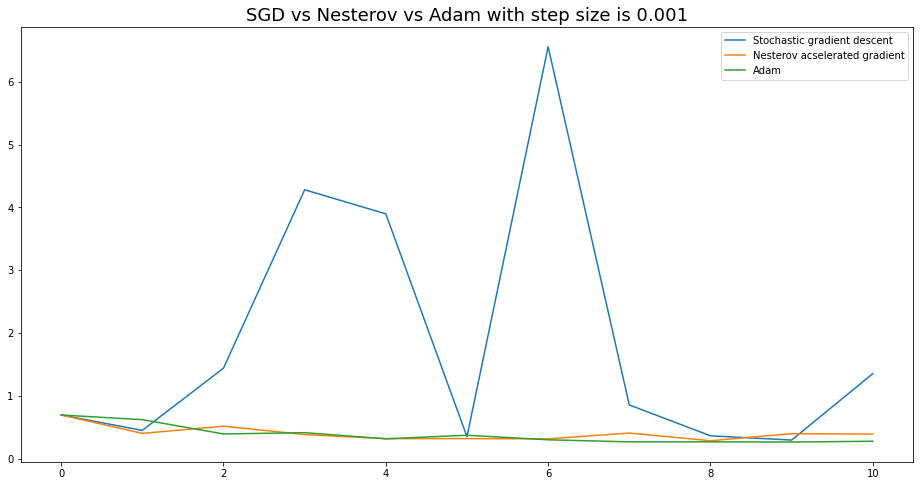

In [53]:
alpha = 1e-3
nimi_batch = 30
epochs = 10
momentum = 0.9
eps = 1e-8
beta_1 = 0.9
beta_2 = 0.999

_, sgd_score, sgd_scor_per_step = sgd(grad, w.copy(), x, y, nimi_batch, epochs, alpha)
_, nesterov_score, nest_scor_per_step = nesterov_acselerated_gradient(grad, w.copy(), x, y, nimi_batch, epochs, alpha, momentum)
_, adam_score, adam_scor_per_step = adam(grad, w.copy(), x, y, nimi_batch, epochs, alpha, eps, beta_1, beta_2)
plt.figure(figsize=(16,8))
plt.plot(sgd_score, label='Stochastic gradient descent')
plt.plot(nesterov_score, label='Nesterov acselerated gradient')
plt.plot(adam_score, label='Adam')
plt.legend()
plt.title(f'SGD vs Nesterov vs Adam with step size is {alpha}', fontsize=18)
plt.show()

## Conclusion:
Here we see that we have not so simple function as in the first task, and thats why acselerated method look worse than more 'smart' Adam method, which better looking for minimun on dificult shapes. But if wee chose low step size $-10^3$ instead of $-10^1$, acselerated method behave better, because it can not "over jump" up the minimum. But for stochastic method it's not help, it stel have huge fluctations.

---